In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# B-Splines

- **B-splines** (short for **Basis splines**) use several Bézier curves joined end-on-end.

- A \( k \)-degree B-spline curve defined by \( n + 1 \) control points will consist of 
  \( n - k + 1 \) Bézier curves.

### Assumptions

- The final point on the first Bézier curve has the same coordinates as the first point of the second Bézier curve (also known as $C^0$ continuity).

- The first derivative at the end of the first Bézier curve is the same as the first derivative at the start of the second Bézier curve (known as $C^1$ continuity).

- The second derivative at the end of the first Bézier curve is the same as the second derivative at the start of the second Bézier curve (known as $C^2$ continuity).\


## Definition

- The equation for a B-spline curve of degree $k$ is defined by:

$$
S(t) = \sum_{i=0}^n N_{i,k}(t) P_i,
$$

where $(P_0, P_1, \ldots, P_n)$ are control points and $N_{i,k}(t)$ are the **basis functions** defined using the **Cox-de Boor recursion formula**:

$$
N_{i,0}(t) =
\begin{cases} 
1 & \text{if } t_i \leq t < t_{i+1}, \\
0 & \text{otherwise},
\end{cases}
$$

and for $j > 0$:

$$
N_{i,j}(t) =
\frac{t - t_i}{t_{i+j} - t_i} N_{i,j-1}(t) +
\frac{t_{i+j+1} - t}{t_{i+j+1} - t_{i+1}} N_{i+1,j-1}(t).
$$


In [12]:
def extend_grid(grid, k):
    """
    Extends the grid on either size by k steps

    Args:
        grid: number of splines x number of control points
        k: spline order

    Returns:
        new_grid: number of splines x (number of control points + 2 * k)
    """
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals
    
    for i in range(k):
        grid = torch.cat([grid[:, :1] - bucket_size, grid], dim=-1)
        grid = torch.cat([grid, grid[:, -1:] + bucket_size], dim=-1)

    return grid

In [13]:
def eval_basis_functions(x_eval, grid, k):
    """
    Returns the value of basis functions defiend for order-k splines and control points defined in `grid`. 

    Args:
        x_eval: number of samples x number of dimensions
        grid: number of splines x number of control points
        k (scalar): order of spline

    Returns:
        bases: number of samples x number of dimensions x number of basis functions
    """
    grid_ = extend_grid(grid, k)
    # Reshape so that each x can be compared to each control point
    grid_ = grid_.unsqueeze(dim=2)
    x_ = x_eval.unsqueeze(dim=1)
    
    for idx in range(k+1):
        if idx == 0:
            bases = (x_ >= grid_[:, :-1]) * (x_ < grid_[:, 1:]) * 1.0 # step function; for each x in between the corresponding knots, the value is 1.
        else:
            bases1 = (x_ - grid_[:, :-(idx+1)]) / (grid_[:, 1:-idx] - grid_[:, :-(idx+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (idx+1):] - x_) / (grid_[:, (idx+1):] - grid_[:, 1:-idx]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases.transpose(1, 2) * 1.0

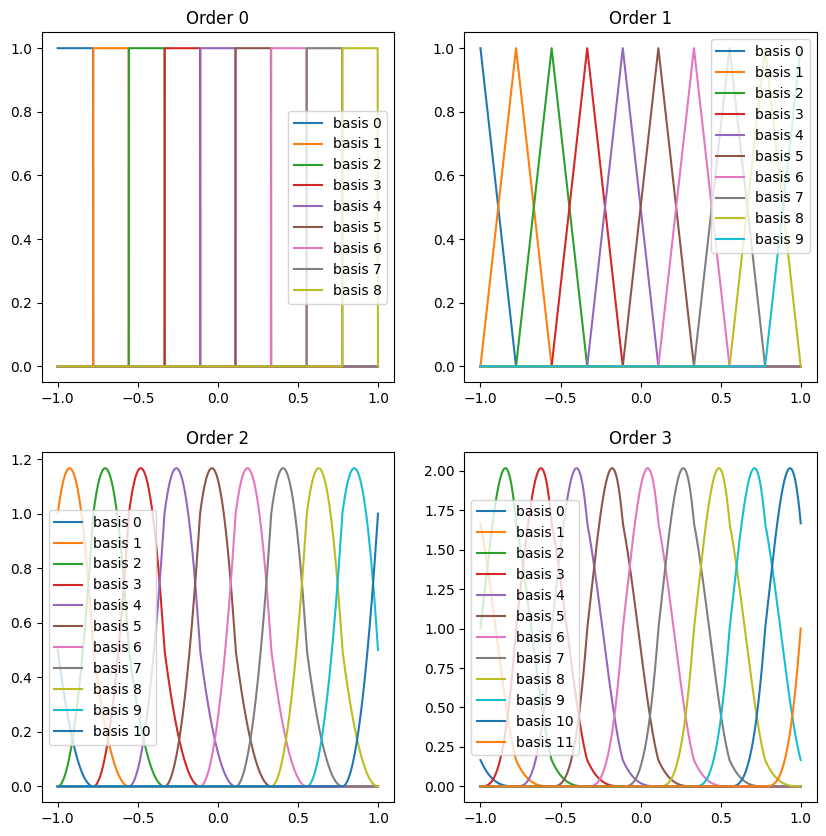

In [ ]:
knots = torch.linspace(-1, 1, steps=10)
x = torch.linspace(-1, 1, steps=1000) # points to evaluate the basis functions

# Reshape knots to be 1 x 10
knots = knots.unsqueeze(dim=0)
# Reshape x to be 1000 x 1
x = x.unsqueeze(dim=1)

ks = [0, 1, 2, 3]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for k in ks:
    plt_idx = k // 2, k % 2
    bases = eval_basis_functions(x, knots, k)
    for i in range(bases.shape[-1]):
        axs[plt_idx].plot(x.squeeze().numpy(), bases[:, 0, i].numpy(), label=f'basis {i}')
    axs[plt_idx].set_title(f'Order {k}')
    axs[plt_idx].legend()
